## Bloque 0


Centralizamos las importaciones y la configuración de gráficos/pandas para todo el cuaderno.


In [1]:
# === Bloque 0: código de referencia ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Configuración
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)
plt.rcParams['figure.figsize'] = (10,5)
sns.set_theme()


## Bloque 1 · Carga de datos e índice temporal


Carga tu fichero (CSV/Excel), convierte la fecha a `datetime` y establece el índice temporal (`set_index`). Comprueba orden y duplicados.


<Axes: xlabel='FECHA'>

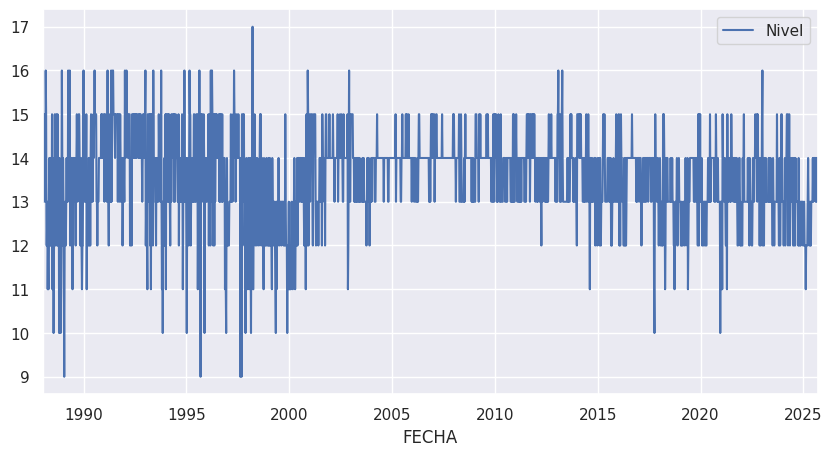

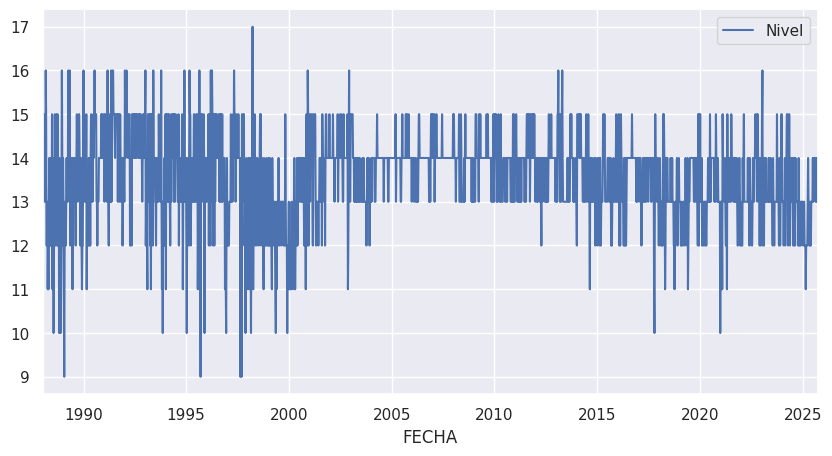

In [3]:
# === Bloque 1: Carga de datos e índice temporal (versión simple) ===

# 1) Cargar
df_embalse = pd.read_csv('/content/Velle_actual.csv')

# 2) Ver tipos
df_embalse.dtypes

# 3) Convertir fecha a datetime (ajusta el formato si lo necesitas)
df_embalse['FECHA'] = pd.to_datetime(df_embalse['FECHA'], format='%d/%m/%Y')

# 4) Ver tipos de nuevo
df_embalse.dtypes

# 5) Poner índice temporal
df_embalse.set_index('FECHA', inplace=True)
#df_embalse.index


# 6) Renombrar columna principal a 'Nivel' (si procede)
df_embalse.columns = ['Nivel']

# 7) Gráfico rápido de la serie original
df_embalse.plot()

# 8) Re-muestreo semanal: primer valor de cada semana
df_week = df_embalse.resample('W').first()
df_week.plot()


### 🧩 Tu turno
- Cambia la **ruta** del archivo si no usas `'/content/Aceña_actual.csv'`.
- Si tu fecha no es `'%d/%m/%Y'`, ajusta el argumento `format` de `to_datetime` (o elimínalo).
- Si tu columna principal no se llama **Nivel**, renómbrala igual que en el ejemplo.


### 🧰 Actividades extra (no se harán en clase)
- Compara `df_embalse.resample('W').first()` con `df_embalse.resample('W').mean()` y observa diferencias en el gráfico.
- Cuenta filas **antes** y **después** del `resample` semanal para verificar la frecuencia:  
  `len(df_embalse)` vs `len(df_week)`.


## Bloque 2 · Exploración y visualización básica


,Nivel
count,1968.000000
mean,13.555894
std,1.032234
min,9.000000
25%,13.000000
50%,14.000000
75%,14.000000
max,17.000000


NaN en 'Nivel' original: 0
NaN en 'Nivel_interp':   0


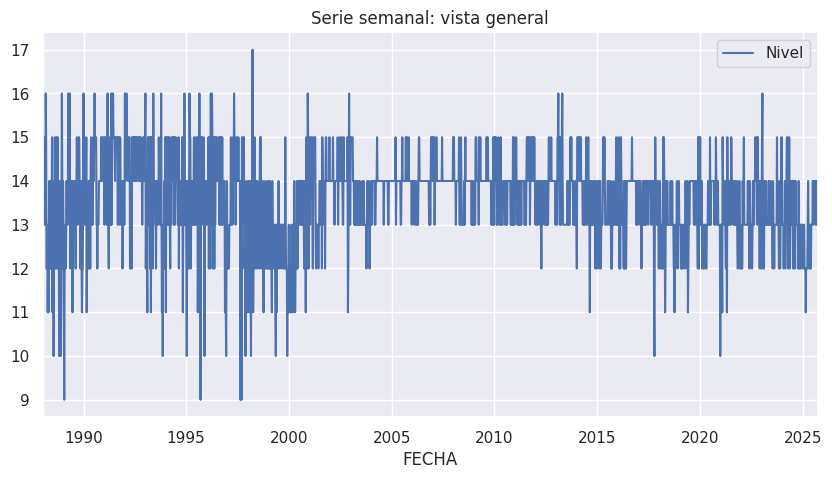

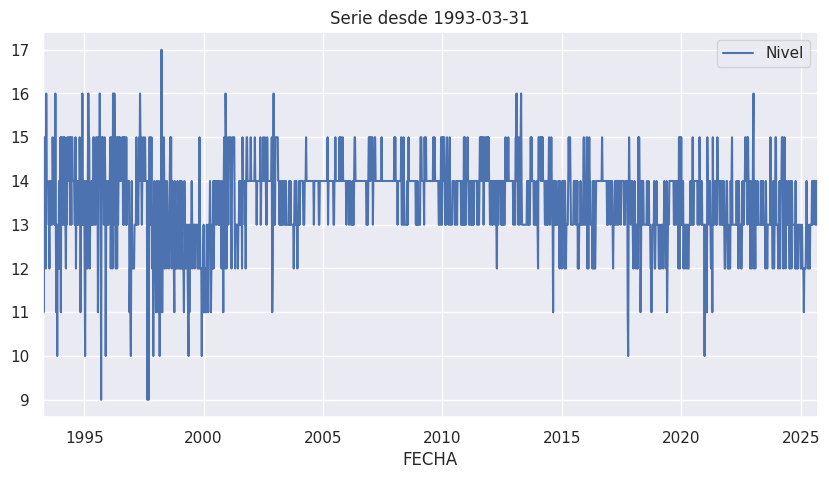

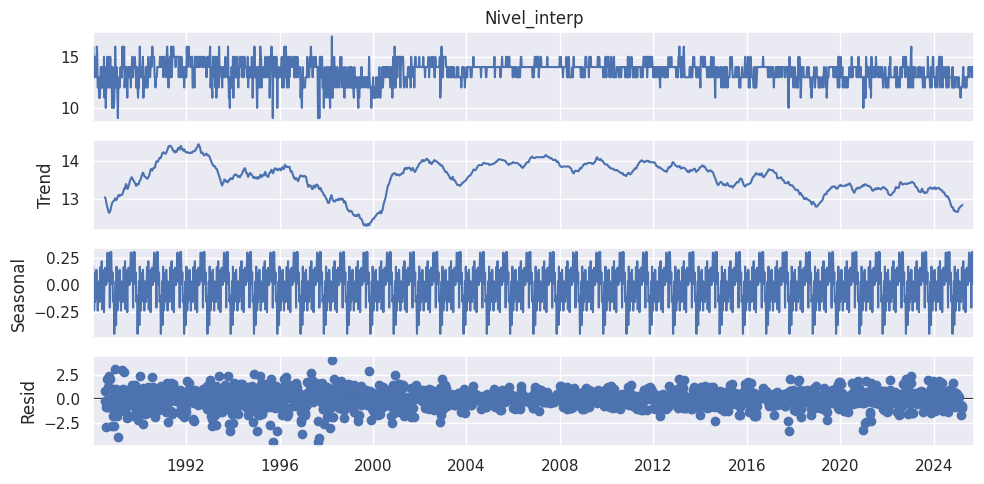

In [4]:
# === Bloque 2: Exploración y visualización básica (versión simple y comentada) ===

# 1) Estadísticos generales de la serie semanal
display(df_week.describe())

# 2) Primer gráfico rápido de la serie completa
df_week.plot(title='Serie semanal: vista general')

# 3) Recorte temporal para ver un tramo (ajusta la fecha de inicio)
df_week.truncate(before='1993-03-31').plot(title='Serie desde 1993-03-31')

# 4) (Opcional) Repite el resumen tras el recorte si quieres comparar
df_week.describe()

# 5) (Opcional) Interpolación de valores faltantes de 'Nivel' (lineal, en ambos sentidos)
df_nuevo = df_week.sort_index().copy()
df_nuevo['Nivel_interp'] = (
    df_nuevo['Nivel']
    .interpolate(limit=8, method='linear', limit_direction='both')
)
# 6) (Opcional) Descomposición estacional simple (si tu serie es semanal, period=52)
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_nuevo['Nivel_interp'], model='additive', period=52)
decomp.plot();


# 7) Comprobación de NaN antes/después
print("NaN en 'Nivel' original:", df_week['Nivel'].isna().sum())
print("NaN en 'Nivel_interp':  ", df_nuevo['Nivel_interp'].isna().sum())

### 🧩 Tu turno
- Cambia la fecha de `truncate(before=...)` para explorar otros periodos.
- Si tu serie no es semanal, ajusta `period` en `seasonal_decompose` (p. ej., mensual → 12).
- Modifica `limit` en la interpolación (4 u 8) y observa el cambio en el recuento de `NaN`.


### 🧰 Actividades extra (no se harán en clase)
- Muestra en una misma figura la serie **original** y la **truncada** para ver qué se excluye.
- Prueba `model='multiplicative'` en la descomposición y comenta diferencias.
- Compara interpolación `linear` vs `time` y cuantifica la variación en el número de `NaN`.


## Bloque 3 · Valores ausentes y atípicos


Detecta valores ausentes (`isna`) y atípicos. Decide imputar (`ffill/bfill`) o eliminar, evitando fuga de información.


np.int64(0)

<Axes: title={'center': 'Serie (después de imputar nulos)'}, xlabel='FECHA'>

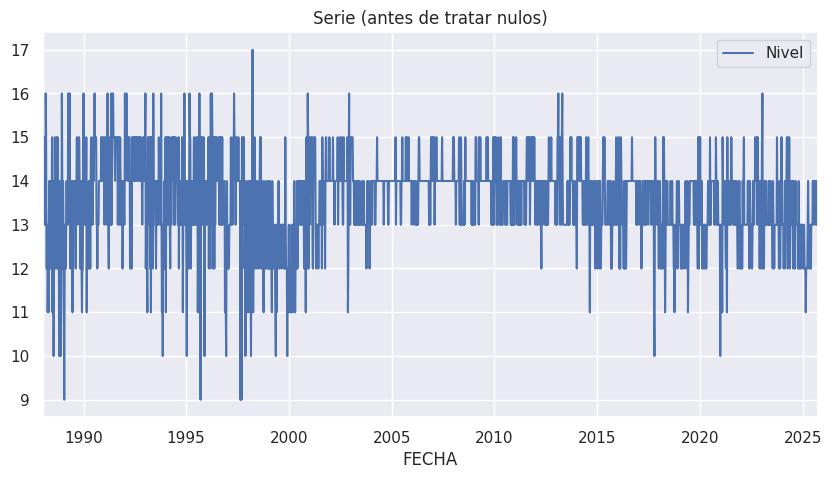

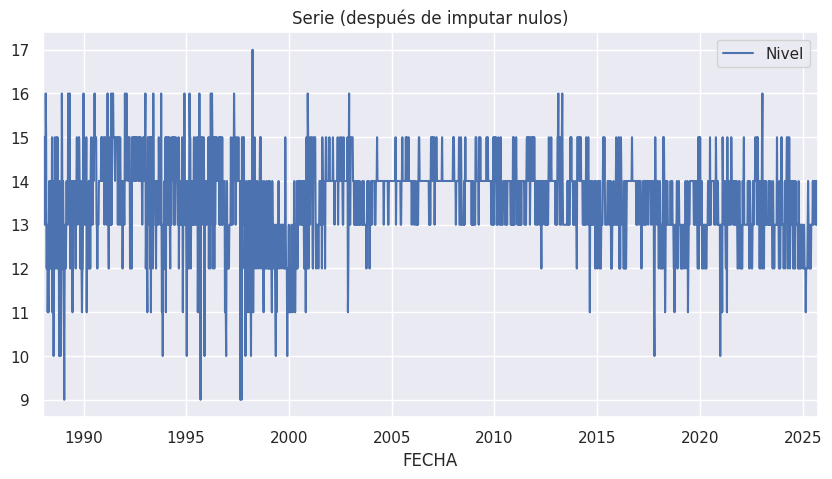

In [5]:
# === Bloque 3: Valores ausentes y atípicos (versión simple) ===

# 1) Conteo de nulos
display(df_week['Nivel'].isna().sum())

# 2) (Opcional) Visual rápido antes de tratar nulos
df_week.plot(title='Serie (antes de tratar nulos)')

# 3) Imputación sencilla (ajusta si no quieres imputar)
#    ffill: rellena con el último valor conocido
#    bfill: rellena hacia adelante lo que no cubra ffill
df_week_imp = df_week.copy()
df_week_imp['Nivel'] = df_week_imp['Nivel'].ffill().bfill()

# 4) Comprobar nulos después
df_week_imp['Nivel'].isna().sum()

# 5) Detección rápida de atípicos con IQR (muy simple)
q1 = df_week_imp['Nivel'].quantile(0.25)
q3 = df_week_imp['Nivel'].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - 1.5 * iqr
lim_sup = q3 + 1.5 * iqr

outliers = df_week_imp[(df_week_imp['Nivel'] < lim_inf) | (df_week_imp['Nivel'] > lim_sup)]
len(outliers), lim_inf, lim_sup

# 6) (Opcional) Visual después de imputar
df_week_imp.plot(title='Serie (después de imputar nulos)')


### 🧩 Tu turno
- Decide si **imputas** (`ffill/bfill`) o prefieres **eliminar** nulos (por ejemplo, `dropna()`).
- Ajusta el criterio de atípicos (usa un factor 1.0, 1.5 o 3.0 en el IQR) y mira cuántos detectas.
- Si tu serie no debe imputarse (p. ej., “0” significa ausencia de evento), **no imputes** y deja los nulos fuera del modelado.


### 🧰 Actividades extra (no se harán en clase)
- Crea una versión **sin imputar** y compara un gráfico lado a lado con la **imputada**.
- Guarda los índices de atípicos y revisa si se agrupan en periodos concretos.
- Prueba una imputación alternativa: `interpolate(method='time')`.


## Bloque 4 · Normalización y estandarización


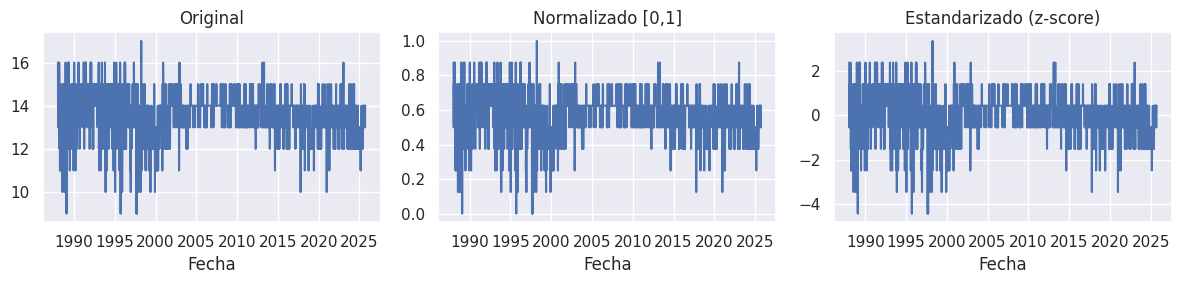

,Nivel,Nivel_normalizado,Nivel_estandarizado
count,1968.000000,1968.000000,1.968000e+03
mean,13.555894,0.569487,-6.426657e-16
std,1.032234,0.129029,1.000254e+00
min,9.000000,0.000000,-4.414748e+00
25%,13.000000,0.500000,-5.386721e-01
50%,14.000000,0.625000,4.303468e-01
75%,14.000000,0.625000,4.303468e-01
max,17.000000,1.000000,3.337404e+00


In [6]:
# === Bloque 4: Normalización y estandarización (versión simple) ===
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Trabajamos sobre una copia para no tocar df_week
df = df_week.copy()
columna = 'Nivel'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

#TIENEN LAS MISMA FORMA, LO UNICO QUE CAMBIA EN ESTE CASO ES LA ESCALA

### 🧩 Tu turno
- Cambia el rango de `MinMaxScaler` a `feature_range=(-1, 1)` y observa la diferencia.
- Añade `RobustScaler` para crear `Nivel_estandarizado_robusto` y compáralo con el z-score.
- Elige la transformación que usarás en tu serie y justifica brevemente por qué.


### 🧰 Actividades extra (no se harán en clase)
- Aplica el escalado solo a columnas numéricas seleccionadas (si tienes más de una variable).
- Compara visualmente `Normalizado [0,1]` vs `(-1,1)` en la misma figura.
- Evalúa el impacto del escalado en una métrica simple (p. ej., correlación entre `Nivel` y `Nivel_lag1` antes/después).


## Bloque 5 · Ingeniería de lags


Genera **lags** (`shift(t)`) para capturar memoria temporal de la serie.


,Nivel,Nivel_lag1,Nivel_lag2,Nivel_lag3,Nivel_lag4,Nivel_lag5
FECHA,,,,,,
2025-07-20,14.0,14.0,13.0,14.0,13.0,13.0
2025-07-27,14.0,14.0,14.0,13.0,14.0,13.0
2025-08-03,14.0,14.0,14.0,14.0,13.0,14.0
2025-08-10,14.0,14.0,14.0,14.0,14.0,13.0
2025-08-17,13.0,14.0,14.0,14.0,14.0,14.0
2025-08-24,14.0,13.0,14.0,14.0,14.0,14.0
2025-08-31,14.0,14.0,13.0,14.0,14.0,14.0
2025-09-07,13.0,14.0,14.0,13.0,14.0,14.0
2025-09-14,14.0,13.0,14.0,14.0,13.0,14.0


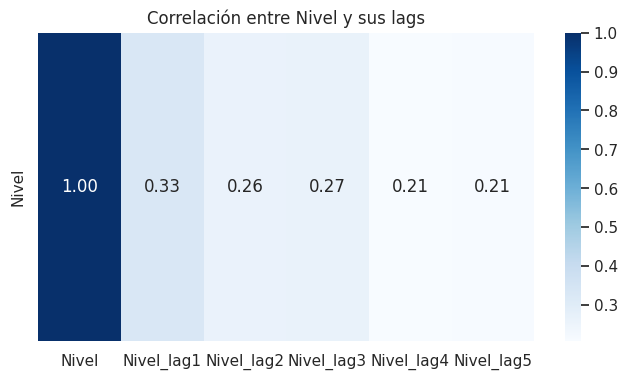

In [7]:
# === Bloque 5: Ingeniería de lags (versión simple y comentada) ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Función para generar lags de una columna
def generar_atributos_desfase(ts_data, var, max_lag):
    """
    Crea columnas var_lag1, var_lag2, ..., var_lag{k} con shift(t).
    ts_data: DataFrame con índice temporal
    var:     nombre de la columna base (p.ej., 'Nivel')
    max_lag: número máximo de retardos
    """
    for t in range(1, max_lag + 1):
        ts_data[f'{var}_lag{t}'] = ts_data[var].shift(t)
    return ts_data

# 2) Generar lags (ejemplo: 5 lags sobre la serie semanal)
df = generar_atributos_desfase(df_week.copy(), 'Nivel', max_lag=5)

# 3) Ver resultado rápido
display(df.tail(10))

# 4) Correlación de cada lag con la variable original (descartando NaN por lags)
lags_cols = [c for c in df.columns if c.startswith('Nivel_lag')]
corr = df[['Nivel'] + lags_cols].dropna().corr()['Nivel'].sort_values(ascending=False)
corr

# 5) Mapa de calor de correlaciones (Nivel vs. sus lags)
plt.figure(figsize=(8, 4))
sns.heatmap(
    df[['Nivel'] + lags_cols].dropna().corr()[['Nivel']].T,
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title('Correlación entre Nivel y sus lags')
plt.show()


### 🧩 Tu turno
- Genera `Nivel_lag1 … Nivel_lag10` (si usas otro nombre de columna, cámbialo).
- Calcula la **correlación** de cada lag con `Nivel` y muestra un **heatmap 1×k**.
- Comenta en 1–2 frases qué lags parecen más informativos.


### 🧰 Actividades extra (no se harán en clase)
- Prueba lags **estacionales** (p.ej., 7 o 12) y compáralos con lags cortos.
- Revisa la **correlación entre lags** para detectar redundancias.
- (Opcional) Traza un **PACF** exploratorio y compáralo con las correlaciones simples.

## Bloque 6 · Ventanas deslizantes (rolling)


Crea **ventanas deslizantes** (`rolling(window)`) con `shift(1)` para evitar fuga: medias, mínimos, máximos, desviaciones.


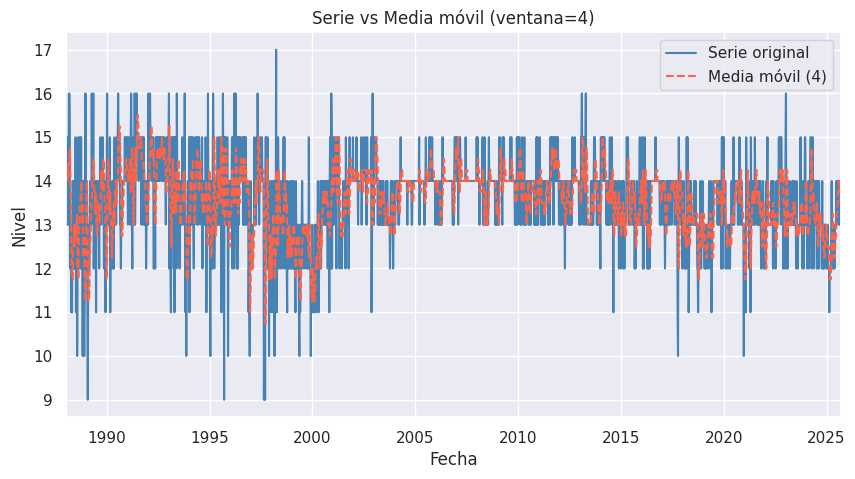

In [8]:
# === Bloque 6: Ventanas deslizantes (rolling) — versión simple ===

df_week = df.copy()
columna = 'Nivel'   # cambia si tu variable principal tiene otro nombre

# 1) Media móvil (ventana 4), desplazando 1 paso para no usar el valor actual
df_week['media_movil_4'] = df_week[columna].shift(1).rolling(window=4).mean()

# 2) Otras estadísticas con la misma ventana
df_week['max_movil_4'] = df_week[columna].shift(1).rolling(window=4).max()
df_week['min_movil_4'] = df_week[columna].shift(1).rolling(window=4).min()
df_week['std_movil_4'] = df_week[columna].shift(1).rolling(window=4).std()

# 3) Vista rápida
df_week[[columna, 'media_movil_4', 'max_movil_4', 'min_movil_4', 'std_movil_4']].head(10)

# 4) Comparación visual: serie original vs media móvil (4)
ax = df_week[columna].plot(label='Serie original', color='steelblue')
df_week['media_movil_4'].plot(ax=ax, label='Media móvil (4)', color='tomato', linestyle='--')
ax.set_title('Serie vs Media móvil (ventana=4)')
ax.set_xlabel('Fecha'); ax.set_ylabel(columna)
ax.legend(); plt.show()

### 🧩 Tu turno
- Crea `media_movil_8` y `var_movil_4` con `shift(1).rolling(...)`.
- Compara visualmente **serie original** vs **media_movil_4**.
- Explica cuándo aumenta/disminuye la suavidad al cambiar el tamaño de ventana.

### 🧰 Actividades extra (no se harán en clase)
- Añade **mediana móvil** con `.rolling().median()` y compárala con la media.
- Prueba un **suavizado exponencial**: `.ewm(span=6).mean()`.
- Compara ventanas 4, 8, 12: ¿cuál capta mejor la tendencia sin retrasarse demasiado?

## Bloque 7 · Ventanas ampliadas (expanding)


Calcula **estadísticas acumuladas** con `expanding()`: resumen con memoria creciente.


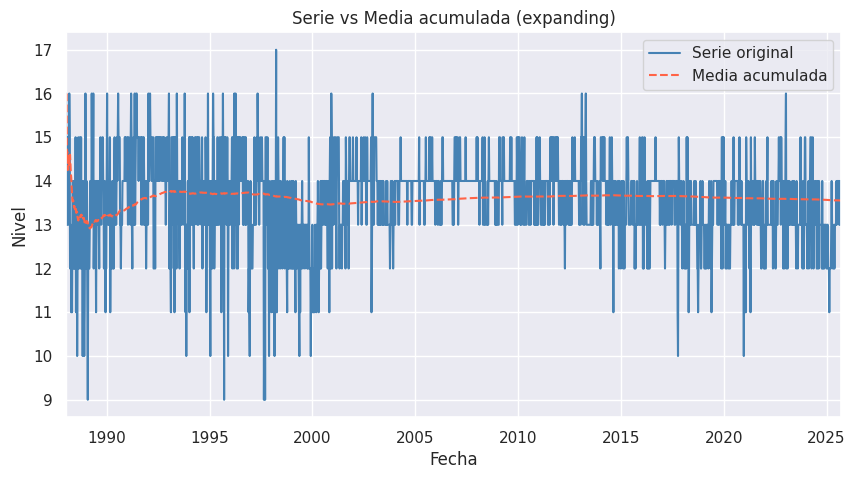

In [9]:
# === Bloque 7: Ventanas ampliadas (expanding) — versión simple ===
import matplotlib.pyplot as plt

columna = 'Nivel'   # cambia si tu variable principal tiene otro nombre

# 1) Estadísticas acumuladas (memoria creciente) con shift(1)
df_week['media_acum'] = df_week[columna].shift(1).expanding().mean()
df_week['suma_acum']  = df_week[columna].shift(1).expanding().sum()
df_week['max_acum']   = df_week[columna].shift(1).expanding().max()
df_week['std_acum']   = df_week[columna].shift(1).expanding().std()

# 2) Extra robusto: mínimo acumulado y, si está disponible, cuartil 25% acumulado
df_week['min_acum']   = df_week[columna].shift(1).expanding().min()
try:
    df_week['q25_acum'] = df_week[columna].shift(1).expanding().quantile(0.25)
except Exception as e:
    # Algunas versiones de pandas no soportan quantile en expanding
    print('Cuartil acumulado no soportado en esta versión de pandas:', e)

# 3) Vista rápida
df_week[[columna, 'media_acum', 'suma_acum', 'max_acum', 'std_acum', 'min_acum']].head(10)

# 4) Comparación visual: serie original vs media acumulada
ax = df_week[columna].plot(label='Serie original', color='steelblue')
df_week['media_acum'].plot(ax=ax, label='Media acumulada', color='tomato', linestyle='--')
ax.set_title('Serie vs Media acumulada (expanding)')
ax.set_xlabel('Fecha'); ax.set_ylabel(columna)
ax.legend(); plt.show()


### 🧩 Tu turno
- Calcula `media_acum`, `suma_acum`, `max_acum`, `std_acum` y **`min_acum`**.
- Grafica **serie vs media_acum** y describe cómo evoluciona la media acumulada.
- Comprueba que `min_acum` **no crece** (debe ser monótona no creciente).

### 🧰 Actividades extra (no se harán en clase)
- Dibuja juntos `min_acum` y `max_acum` como **envolvente histórico**.
- Si hay cambio de régimen, reinicia el cálculo a partir de una fecha y compara.
- Compara `media_acum` vs `media_movil_12` (retraso vs estabilidad).

In [ ]:
df_week.describe()

## Bloque 8 · Integración y prueba de modelado


Prepara `X` e `y` e integra un **modelo base** (árbol) para validar el pipeline (sanity check).


Rendimiento medio (CV=5, R^2): -0.155


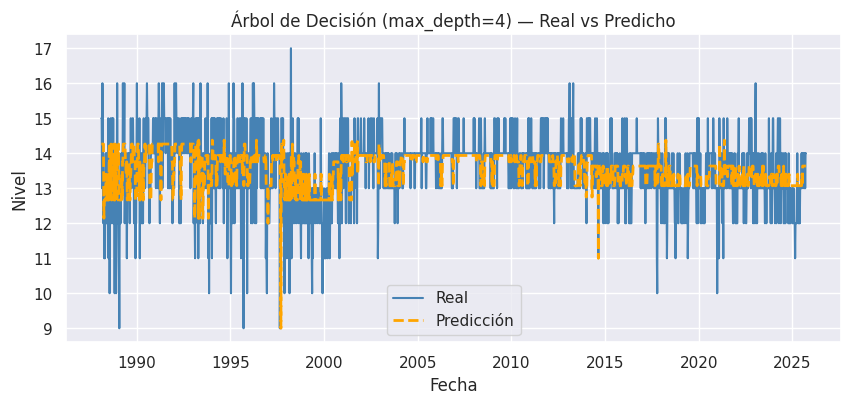

In [10]:
# === Bloque 8: Integración y prueba de modelado (versión simple) ===
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score  # (opcional) TimeSeriesSplit ver abajo
from sklearn.tree import DecisionTreeRegressor

# 1) Selección de atributos (usa exactamente los que ya has creado)
atributos = [
    'Nivel_lag1','Nivel_lag2','Nivel_lag3','Nivel_lag4','Nivel_lag5',
    'media_movil_4','max_movil_4','min_movil_4','std_movil_4',
    'media_acum','suma_acum','max_acum','std_acum'
]

X = df_week[atributos]
y = df_week['Nivel']

# 2) Eliminar filas con NaN (por lags/ventanas) y alinear índices
X = X.dropna()
y = y.loc[X.index]

# 3) Modelo base (árbol poco profundo para evitar sobreajuste)
model = DecisionTreeRegressor(max_depth=4, random_state=42)

# 4) Validación cruzada rápida (por defecto R^2). Para series, mejor TimeSeriesSplit (ver comentario)
scores = cross_val_score(model, X, y, cv=5)
print(f"Rendimiento medio (CV=5, R^2): {scores.mean():.3f}")

# 5) Entrenar en todo el conjunto y predecir (solo para visualizar el pipeline)
model.fit(X, y)
y_pred = model.predict(X)

# 6) Visualización: real vs predicho
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label='Real', color='steelblue')
plt.plot(y.index, y_pred, label='Predicción', color='orange', linestyle='--', linewidth=2)
plt.title('Árbol de Decisión (max_depth=4) — Real vs Predicho')
plt.xlabel('Fecha'); plt.ylabel('Nivel'); plt.legend()
plt.show()

# — Nota —
# Si quieres usar un CV temporal más correcto:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# scores = cross_val_score(model, X, y, cv=tscv)
# print(f"Rendimiento medio (TimeSeriesSplit, R^2): {scores.mean():.3f}")


### 🧩 Tu turno
- Construye `X` con lags (1..5 o 1..10), rolling (4/8) y expanding; alinea `y` y `dropna`.
- Entrena un `DecisionTreeRegressor(max_depth=4)` y reporta el **CV medio** (R² o MAE).
- Grafica **Real vs Predicho** en el conjunto utilizado.

### 🧰 Actividades extra (no se harán en clase)
- Barrido de `max_depth` en {3,5,7} y comenta si ves **sobreajuste**.
- Deja un **hold-out** (último 20%) y reporta **MAE/R²** en test.
- Compara contra un **baseline ingenuo** (predicción = `Nivel_lag1`) y cuantifica la mejora.

## Entrega y verificación (Bloques 5 al 8)

1) Completa los **Bloques 5–8** en este notebook.
2) **No edites** las celdas de **Autoverificación** y **Resumen**.
3) Al terminar:
   - Ejecuta **Autoverificación → comprueba que la mayoría de mensajes muestren **OK**.
   - Ejecuta **Resumen** → deja el JSON impreso.
4) Entrega el `.ipynb` con esas salidas visibles. (Opcional: adjunta `serie_preparada.csv`.)

> Si algún punto marca **REVISAR**, corrige tu celda “🧩 Tu turno” del bloque correspondiente y vuelve a ejecutar Autochequeo.


In [ ]:
# ✅ Autoverificación (Bloques 5–8)
def ok(name, cond):
    print(f"[{name}] {'OK' if cond else 'REVISAR'}")

# --- B5 · Lags ---
lags = [f'Nivel_lag{i}' for i in range(1,11)]
ok("B5 lags 1..10", all(c in df_week.columns for c in lags))

# --- B6 · Rolling ---
ok("B6 media_movil_4", 'media_movil_4' in df_week.columns)
ok("B6 media_movil_8", 'media_movil_8' in df_week.columns)
ok("B6 var_movil_4",  'var_movil_4'  in df_week.columns)

# --- B7 · Expanding ---
ok("B7 media_acum", 'media_acum' in df_week.columns)
ok("B7 suma/max/std", all(c in df_week.columns for c in ['suma_acum','max_acum','std_acum']))
if 'min_acum' in df_week.columns:
    mono_no_crece = (df_week['min_acum'].ffill().fillna(df_week['min_acum'].max())
                     .diff().dropna() <= 0).all()
    ok("B7 min_acum no crece", mono_no_crece)
else:
    ok("B7 min_acum presente", False)

# --- B8 · Pipeline mínimo ---
atributos = [
    'Nivel_lag1','Nivel_lag2','Nivel_lag3','Nivel_lag4','Nivel_lag5',
    'media_movil_4','max_movil_4','min_movil_4','std_movil_4',
    'media_acum','suma_acum','max_acum','std_acum'
]
ok("B8 atributos en df", all(c in df_week.columns for c in atributos))
try:
    X = df_week[atributos].dropna()
    y = df_week.loc[X.index, 'Nivel']
    ok("B8 tamaños X/y razonables", (len(X) > 50) and (len(X) == len(y)))
except Exception as e:
    ok("B8 construcción X/y", False); print("Detalle:", e)


In [ ]:
import json

summary = {
    "n_obs": int(len(df_week)),
    "cols_creadas": [
        c for c in df_week.columns
        if c.startswith(('Nivel_lag','media_movil','var_movil','max_movil',
                         'min_movil','std_movil','media_acum','suma_acum',
                         'max_acum','std_acum','min_acum'))
    ],
    "lags_ok": all(f'Nivel_lag{i}' in df_week.columns for i in range(1,11)),
    "rolling_ok": all(c in df_week.columns for c in ['media_movil_4','media_movil_8','var_movil_4']),
    "expanding_ok": all(c in df_week.columns for c in ['media_acum','suma_acum','max_acum','std_acum']),
}
print(json.dumps(summary, indent=2))
